In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from collections import Counter
import gc
from datetime import datetime

from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss, accuracy_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm


In [7]:
df = pd.read_parquet("/kaggle/input/train-final/final_features.parquet")
df.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,78.254230,101.231864,93.558436,82.457197,17.701677,16.892752,18.082342,115.977202,107.869210,76.757549
1,1,0,0.799984,0.444440,0.599988,0.599988,0.699993,0.466664,0.0,1.0,...,73.812549,50.885972,82.440207,4.892528,155.426500,99.566298,77.538997,66.205757,108.603860,162.959745
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,77.619205,25.180800,118.439353,114.361097,41.180234,138.513988,145.557087,221.677197,3.016149,229.145969
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,38.631719,76.813484,21.755756,28.060877,35.912469,18.611610,77.108740,150.612036,32.371204,2.647544
4,4,0,0.499988,0.199998,0.666644,0.666644,0.571420,0.307690,0.0,1.0,...,104.460834,60.771836,117.491438,65.466095,145.510048,65.296788,8.415168,30.952414,23.655576,4.182842


In [8]:
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [4]:
df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,78.254230,101.231864,93.558436,82.457197,17.701677,16.892752,18.082342,115.977202,107.869210,76.757549
1,0.799984,0.444440,0.599988,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,73.812549,50.885972,82.440207,4.892528,155.426500,99.566298,77.538997,66.205757,108.603860,162.959745
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,77.619205,25.180800,118.439353,114.361097,41.180234,138.513988,145.557087,221.677197,3.016149,229.145969
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,38.631719,76.813484,21.755756,28.060877,35.912469,18.611610,77.108740,150.612036,32.371204,2.647544
4,0.499988,0.199998,0.666644,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,104.460834,60.771836,117.491438,65.466095,145.510048,65.296788,8.415168,30.952414,23.655576,4.182842


In [9]:
gc.collect()

72

In [ ]:
"""for i in tqdm(df.columns):
    df[i] = df[i].apply(pd.to_numeric)"""

In [10]:
y_true = list(map(int, y_true.values))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df,y_true, stratify=y_true, test_size=0.30)

In [8]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 626)
Number of data points in test data : (121287, 626)


In [9]:
print("-"*10, 'Distribution of output variable in train data', "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print(f"Class 0: {round(int(train_distr[0])/train_len * 100,2)}%, Class 1: {round(int(train_distr[1])/train_len * 100,2)}%\n")

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print(f"Class 0: {round(int(test_distr[0])/test_len * 100,2)}%, Class 1: {round(int(test_distr[1])/test_len * 100,2)}%")

---------- Distribution of output variable in train data ----------
Class 0: 63.08%, Class 1: 36.92%

---------- Distribution of output variable in test data ----------
Class 0: 63.08%, Class 1: 36.92%


In [7]:
# For Ploting confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = ((C.T)/(C.sum(axis=1))).T  # divide each element of confusion matrix with sum of elements in that column
    B = C/C.sum(axis=0) # divide each element of confusion matrix with sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap = sns.light_palette("pink")
    
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel("Predicted Class",fontsize=15)
    plt.ylabel("Original Class",fontsize=15)
    plt.title("Confusion Matrix",fontsize=20)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.title("Precision matrix",fontsize=20)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.title("Recall matrix",fontsize=20)
    
    plt.show()

In [ ]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15),"\n")

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### First Benchmark Model : Logistic Regression

In [8]:
start = datetime.now()
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
print(f"Execution Time = {datetime.now()-start}")

Execution Time = 0:00:33.982728


In [ ]:
sig_clf_log = CalibratedClassifierCV(logistic, method="isotonic")
sig_clf_log.fit(X_train, y_train)

In [ ]:
predict_y  = sig_clf_log.predict_proba(X_train)
log_loss_error = log_loss(y_train, predict_y, labels=logistic.classes_, eps=1e-15)
print("Logistic Regression --> Train --> Log-Loss = ",log_loss_error)

predict_y  = sig_clf_log.predict_proba(X_test)
log_loss_error = log_loss(y_test, predict_y, labels=logistic.classes_, eps=1e-15)
print("Logistic Regression --> Test --> Log-Loss = ",log_loss_error)

plot_confusion_matrix(y_test, np.argmax(predict_y,axis=1))

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

In [ ]:
rf

In [ ]:
sig_clf = CalibratedClassifierCV(rf, method="isotonic")
sig_clf.fit(X_train, y_train)

In [ ]:
xgb_grid = GridSearchCV(xgb, )

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The train log loss is:",log_loss(y_train, bst.predict(d_train), labels=logistic.classes_, eps=1e-15))
print("The test log loss is:",log_loss(y_test, predict_y, labels=logistic.classes_, eps=1e-15))

In [ ]:
pickle.dump(file = open("xgboost_2.pickle","wb"),obj = bst)

In [ ]:
bst.predict()

In [ ]:
iso_clf_xgb2 = CalibratedClassifierCV(bst, method="isotonic")
iso_clf_xgb2.fit(X_train, y_train)

In [9]:
import optuna
from xgboost import XGBClassifier

In [18]:
def objective(trial,data = X_train, target = y_train):
    param = {
        #'tree_method' : 'gpu_hist',
        'reg_lambda' : trial.suggest_loguniform('lambda', 1e-4, 10.0),
        'reg_alpha' :  trial.suggest_loguniform('alpha', 1e-4, 10.0),
        'booster' : trial.suggest_categorical('booster',['gbtree','dart']),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'subsample' : trial.suggest_categorical('subsample', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'learning_rate' : trial.suggest_categorical('learning_rate',[.00001,.0003,.008,.02,.01,1,10,20]),
        'n_estimators' : trial.suggest_categorical('n_estimator',[50,100,200,300,400]),
        'max_depth' : trial.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12]),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,200),
        'verbosity' : 2,
        'eval_metric':'logloss',
        'random_state' : 30
    }
    xgb_reg_model = XGBClassifier(objective="binary:logistic",**param)
    xgb_reg_model.fit(X_train,y_train, eval_set = [(X_test,y_test)], verbose = True)
    pred_xgb = xgb_reg_model.predict(X_test)
    logloss = log_loss(y_test, pred_xgb, labels=logistic.classes_, eps=1e-15)
    return logloss

In [ ]:
start = datetime.now()
find_param = optuna.create_study(direction='minimize')
find_param.optimize(objective, n_trials = 10)
params2 = find_param.best_params
print(params2)
print("Executed in {}".format(datetime.now()-start))

[I 2023-03-05 07:17:38,607] A new study created in memory with name: no-name-ec62e657-2c17-41f9-9e79-6f03fcbd164e


[07:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation_0-logloss:1.33907
[07:18:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-logloss:21.53289
[07:18:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-logloss:9.78982
[07:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation_0-logloss:11.83746
[07:18:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[4]	validation_0-logloss:12.80813
[07:18:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[5]	validation_0-logloss:12.80813
[07:18:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[6]	valida

[I 2023-03-05 07:19:03,421] Trial 0 finished with value: 12.008258208424843 and parameters: {'lambda': 0.07464972826352886, 'alpha': 0.9485730877796527, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 10, 'n_estimator': 50, 'max_depth': 9, 'min_child_weight': 168}. Best is trial 0 with value: 12.008258208424843.


[07:19:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[07:19:15] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69314
[07:19:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[07:19:16] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[1]	validation_0-logloss:0.69314
[07:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[07:19:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.69314
[07:19:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[07:19:22] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[3]	validation_0-logloss:0.69313
[07:19:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[07:19:25] INFO: ../src/gbm/gbt

[I 2023-03-05 07:32:16,810] Trial 1 finished with value: 7.818380652402497 and parameters: {'lambda': 6.030861543149518, 'alpha': 1.0638485370168627, 'booster': 'dart', 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 1e-05, 'n_estimator': 50, 'max_depth': 3, 'min_child_weight': 113}. Best is trial 1 with value: 7.818380652402497.


[07:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=8
[07:32:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.68853
[07:32:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=8
[07:32:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[1]	validation_0-logloss:0.68432
[07:32:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=8
[07:32:45] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.67992
[07:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=8
[07:32:54] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[3]	validation_0-logloss:0.67645
[07:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=8
[07:33:02] INFO: ../src/gb

[I 2023-03-05 08:29:43,907] Trial 2 finished with value: 6.239337418096297 and parameters: {'lambda': 2.4362664374759673, 'alpha': 0.27868763499900795, 'booster': 'dart', 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimator': 100, 'max_depth': 8, 'min_child_weight': 143}. Best is trial 2 with value: 6.239337418096297.


[08:29:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation_0-logloss:0.69302
[08:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-logloss:0.69292
[08:30:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation_0-logloss:0.69278
[08:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation_0-logloss:0.69265
[08:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation_0-logloss:0.69254
[08:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation_0-logloss:0.69244
[08:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=7
[6]	validat

[I 2023-03-05 08:31:59,883] Trial 3 finished with value: 6.722022845782673 and parameters: {'lambda': 1.0456766631123489, 'alpha': 0.03348378131911038, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'subsample': 0.2, 'learning_rate': 0.0003, 'n_estimator': 50, 'max_depth': 7, 'min_child_weight': 171}. Best is trial 2 with value: 6.239337418096297.


[08:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[08:32:17] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69300
[08:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=8
[08:32:25] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[1]	validation_0-logloss:0.69286
[08:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=8
[08:32:34] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.69272
[08:32:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[08:32:43] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[3]	validation_0-logloss:0.69258
[08:32:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=8
[08:32:53] INFO: ../src/gb

In [ ]:
param2

In [12]:
gc.collect()

75

In [15]:
params = {'n_estimators': 400,    ### 100
          'reg_lambda': 0.47178174724444527, 
          'reg_alpha': 0.008450456795608624, 
          'colsample_bytree': 0.7, 
          'subsample': 0.3, 
          'learning_rate': 0.01, 
          'max_depth': 12, 
          'min_child_weight': 74}

params3= {'lambda': 0.0016711225229536217, 
          'alpha': 0.7332325914607827, 
          'booster': 'dart', 
          'colsample_bytree': 0.5, 
          'subsample': 0.5, 
          'learning_rate': 0.01, 
          'n_estimators': 400, 
          'max_depth': 11, 
          'min_child_weight': 85}

In [16]:
start = datetime.now()
xgb_reg_model = XGBClassifier(objective="binary:logistic",
                              #tree_method = 'gpu_hist',
                              verbosity = 1, 
                              eval_metric='logloss', 
                              random_state=30,
                              **params3)
"""xgb_reg_model.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 1)
print("Executed in {}".format(datetime.now()-start))
"""

'xgb_reg_model.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 1)\nprint("Executed in {}".format(datetime.now()-start))\n'

In [10]:
import xgboost as xgb
xgb_reg_trained_model = xgb.XGBClassifier()
xgb_reg_trained_model.load_model("/kaggle/input/models-xg/xgboost4_non_calibrated.json")

In [11]:
xgb_reg_trained_model

XGBClassifier(alpha=0.7332325914607827, base_score=0.5, booster='dart',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.0016711225229536217,
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=85,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=30, ...)

In [12]:
gc.collect()

235

In [13]:
start = datetime.now()
sig_clf = CalibratedClassifierCV(xgb_reg_trained_model, method="isotonic")
sig_clf.fit(X_train, y_train)
print("Execution Time =",datetime.now() - start )

Execution Time = 0:23:11.157787


In [12]:
import pickle
sig_clf = pickle.load(open("/kaggle/input/model-xg-cali/xgboost4_calibrated.pickle","rb"))

Calibrated XGBoost --> Test --> Log-Loss =  0.33695065324949736


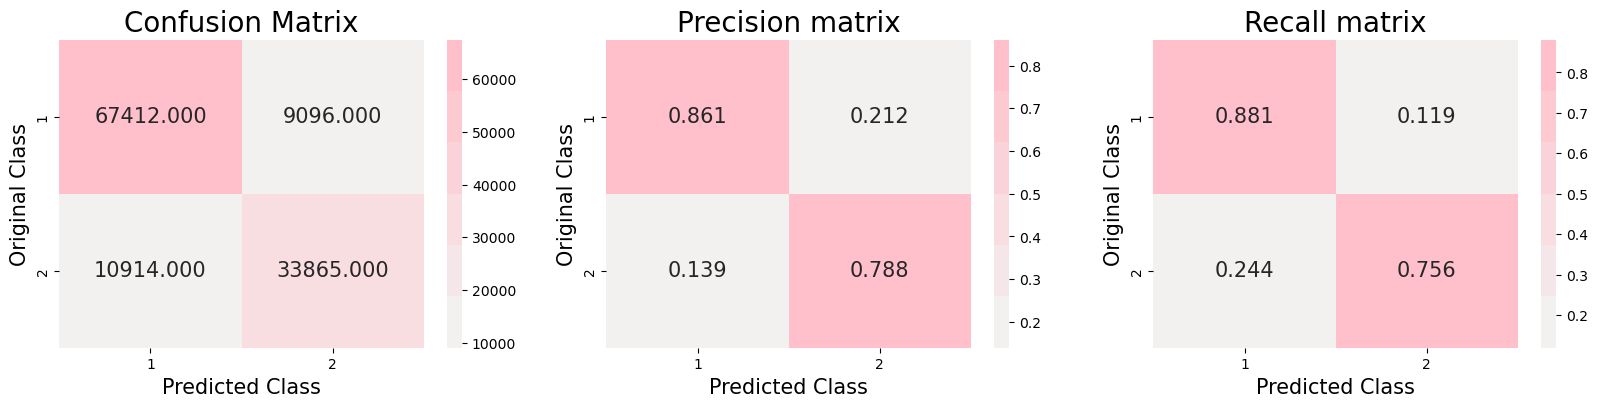

In [15]:
predict_y  = sig_clf.predict_proba(X_test)
log_loss_error = log_loss(y_test, predict_y, labels=logistic.classes_, eps=1e-15)
print("Calibrated XGBoost --> Test --> Log-Loss = ",log_loss_error)

plot_confusion_matrix(y_test, np.argmax(predict_y,axis=1))

In [ ]:
predict_y  = sig_clf.predict_proba(X_train)
log_loss_error = log_loss(y_train, predict_y, labels=logistic.classes_, eps=1e-15)
print("Calibrated XGBoost --> Train --> Log-Loss = ",log_loss_error)

In [ ]:
pred_xgb = xgb_reg_model.predict(X_test)
logloss = log_loss(y_test, pred_xgb, labels=logistic.classes_, eps=1e-15)

XGBoost --> Train --> Log-Loss =  0.332329777713177
XGBoost --> Test --> Log-Loss =  0.3341544307582291


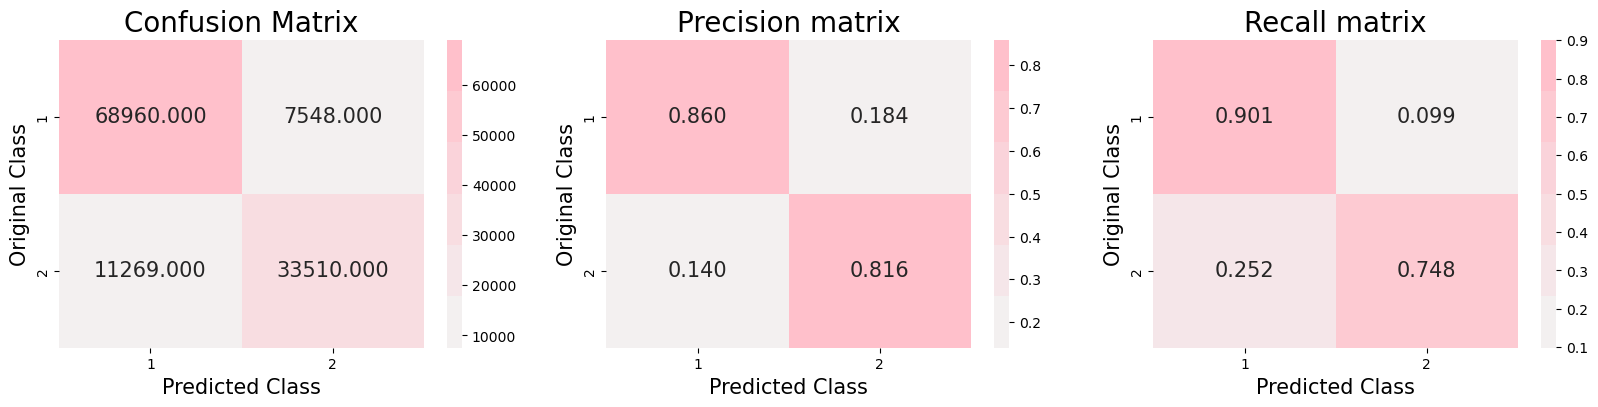

In [27]:
predict_y  = xgb_reg_trained_model.predict_proba(X_train)
log_loss_error = log_loss(y_train, predict_y, labels=logistic.classes_, eps=1e-15)
print("XGBoost --> Train --> Log-Loss = ",log_loss_error)

predict_y  = xgb_reg_trained_model.predict_proba(X_test)
log_loss_error = log_loss(y_test, predict_y, labels=logistic.classes_, eps=1e-15)
print("XGBoost --> Test --> Log-Loss = ",log_loss_error)

plot_confusion_matrix(y_test, np.argmax(predict_y,axis=1))

In [ ]:
fig = plt.figure(figsize=(10, 10))
colors = plt.cm.get_cmap("Dark2")


calibration_displays = {}
display = CalibrationDisplay.from_estimator(
    sig_clf,
    X_test,
    y_test,
    n_bins=10,
    name="XGBoost",
    color=colors(0),
)
calibration_displays["XGBoost"] = display

display.plot()
plt.title("Calibration plots for XGBoost")
plt.show()

In [14]:
import pickle
pickle.dump(file = open("xgboost4_calibrated.pickle","wb"),obj = sig_clf)

In [ ]:
pickle.dump(file = open("xgboost_non_calibrated.pickle","wb"),obj = xgb_reg_model)